In [48]:
# import dependiencies
# ! pip install pandas openpyxl
# ! pip install gspread oauth2client
! pip install pyspark-eda
import io
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import col, count, sum, format_number, when, mean, regexp_replace,stddev, format_number # Import format_number
from pyspark.sql.types import DoubleType, FloatType, IntegerType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/My Drive/Project4-Loan_Analysis'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Asif  data  notebooks  Resources


Conducting EDA on a subset of the data (corresponding to year 2018) given extensive file size.

In [11]:
from pyspark.sql import SparkSession

# 1. Create Spark session
spark = SparkSession.builder.appName("GoogleDriveCSV").getOrCreate()

# 2. Define file path (make sure folder name is correct: 'Resources' vs 'resources')
file_path = '/content/drive/MyDrive/Project4-Loan_Analysis/data/Loan_2018.csv'  # <-- double-check that folder name is lowercase

# 3. Load the CSV file
df = spark.read.csv(file_path, header=True, inferSchema=True)

# 4. Show first few rows
df.show(5)

+----+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------+----------+--------------+----------+-------------------+----------+-----------+----------+----+----+------------------+------------------+--------+----------+-----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+-----

We need an unique identifier column, so we can keep member_id as index
Joint applications - we will combine the joint employment income, dti, etc. into a single column.

Multiple columns not really needed - e.g., total_pmt_inv when we have an installment column, or disboursement_method (very unlikely to contribute to the analysis).

Multiple columns need cleaning (standardization, potentially bucketing based on distribution) - e.g. emp_length, purpose or title (no need to keep both), etc.)


In [12]:
# Get summary statistics for all numerical columns
df.describe().show()

# Count distinct values in each categorical column
for col in [col for col in df.columns if df.select(col).dtypes[0][1] == 'string']:
    print(f"Column: {col}, Distinct Values: {df.select(col).distinct().count()}")



+-------+----+---------+------------------+------------------+------------------+----------+------------------+-----------------+------+---------+------------------+----------+--------------+-----------------+-------------------+------------------+----------+----+----+-------+--------+--------+----------+------------------+------------------+------------------+----------------------+----------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+-------------------+-----------------+-----------------------+-----------------+--------------------------+---------------------------+-----------+----------------+------------------+------------------+-------------------------+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---

In [13]:
# desribe the dataset
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: date (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: double 

In [14]:
# Get the number of columns in the DataFrame
num_columns = len(df.columns)

print(f"The DataFrame has {num_columns} columns.")


The DataFrame has 145 columns.


In [15]:
# count null values in each column
from pyspark.sql.functions import col, sum

# Count null values for each column
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()


+------+---------+---------+-----------+---------------+----+--------+-----------+-----+---------+---------+----------+--------------+----------+-------------------+-------+-----------+----------+------+------+-------+-----+--------+----------+----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+--------------------+-----------+-----

Evaluate which columns with null values make sense vs. which do not make sense, and whether there's any value in the column to dig deeper. For instance, seeing null values for debt-to-income ratio (dti) which is an important feature for loan analysis. Consider managing this.

In [16]:
# Select columns that have only null values
columns_with_all_nulls = [c for c in df.columns if df.filter(col(c).isNotNull()).count() == 0]

print(f"Columns with only null values: {columns_with_all_nulls} can be excluded from our analysis")


Columns with only null values: ['id', 'member_id', 'url', 'desc'] can be excluded from our analysis


In [19]:
# Identify numeric columns
numeric_columns = [col for col, dtype in df.dtypes if dtype in ('int', 'double')]

print(f"Numeric columns: {numeric_columns}")


columns_with_zeros = []
for c in numeric_columns:
    zero_count = df.select(sum(when(col(c) == 0, 1).otherwise(0)).alias("zero_count")).collect()[0]["zero_count"]
    if zero_count > 0:
        columns_with_zeros.append(c)

print(f"Columns with zero values: {columns_with_zeros}")

# Count the number of columns with zero values
zero_column_count = len(columns_with_zeros)
print(f"Number of columns with zero values: {zero_column_count}")


Numeric columns: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'annual_inc_joint', 'dti_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev

In [20]:
df.groupBy('loan_status').count().show()

+------------------+------+
|       loan_status| count|
+------------------+------+
|        Fully Paid| 40240|
|           Default|     9|
|   In Grace Period|  2901|
|       Charged Off|  6942|
|Late (31-120 days)|  6509|
|           Current|437318|
| Late (16-30 days)|  1323|
+------------------+------+



Note a VERY low number of defaulted loans... full data set is very likely imbalanced, which can make predicting troubled loans more difficult.

In [22]:
df.groupBy('grade').count().orderBy('grade', ascending=True).show()

# Remove .show() to assign the DataFrame to grouped_df
grouped_df = df.groupBy('loan_status', 'grade').count().orderBy('loan_status', ascending=True)

# Define a window to partition by 'grade'
window = Window.partitionBy('grade')

# Calculate the proportion using window functions
proportion_df = grouped_df.withColumn(
    'proportion',
    col('count') / sum(col('count')).over(window)
)

# Format the proportion as a percentage
proportion_df = proportion_df.withColumn(
    'proportion_percentage',
    format_number('proportion', 2)
)

# Show the results
proportion_df.show(50)


+-----+------+
|grade| count|
+-----+------+
|    A|135177|
|    B|141365|
|    C|126850|
|    D| 69046|
|    E| 18958|
|    F|  3175|
|    G|   671|
+-----+------+

+------------------+-----+------+--------------------+---------------------+
|       loan_status|grade| count|          proportion|proportion_percentage|
+------------------+-----+------+--------------------+---------------------+
|       Charged Off|    A|   518|0.003832012842421418|                 0.00|
|           Current|    A|123733|  0.9153406274736087|                 0.92|
|           Default|    A|     1|7.397708190002737E-6|                 0.00|
|        Fully Paid|    A| 10071| 0.07450231918151756|                 0.07|
|   In Grace Period|    A|   304|0.002248903289760832|                 0.00|
| Late (16-30 days)|    A|   120|8.877249828003284E-4|                 0.00|
|Late (31-120 days)|    A|   430|0.003181014521701177|                 0.00|
|       Charged Off|    B|  1400|0.009903441445902451|          

As suspected, higher rated loans have better metrics/less troubled. This is a good sign; means the loans were properly analyzed before making into the data set, and means the data set can be trusted for predictions (managing class imbalance, of course). \
For the full data set, we can group group non-current and defaulted loans into a single class called "trouble".

In [23]:
df.select('emp_title').distinct().show()

+--------------------+
|           emp_title|
+--------------------+
|   Exhibits director|
|                 CSR|
| Pharmacist Director|
|Lead Sales Consul...|
|     Clinic Director|
|           Physician|
|Journeyman Electr...|
|Mortgage Loan off...|
|Digital Marketing...|
|  Corporate Director|
|Physical therapis...|
|    GES Coordinator |
|      Dispatch Clerk|
|           machinist|
|   Brand Coordinator|
|    Dedicated Driver|
|         Bank Teller|
|  English Instructor|
| Route sales manager|
|        library tech|
+--------------------+
only showing top 20 rows



Dirty column - evaluate value in engaging in regex/standardization vs. predictive power contribution...

In [27]:
# Register the DataFrame as a temporary view
df.createOrReplaceTempView("df")

#Show unique values in term and grade columns
spark.sql(f"SELECT DISTINCT term FROM df").show()
spark.sql(f"SELECT DISTINCT grade FROM df").show()
spark.sql(f"SELECT AVG (loan_amnt) FROM df").show()

#

+----------+
|      term|
+----------+
| 36 months|
| 60 months|
+----------+

+-----+
|grade|
+-----+
|    F|
|    E|
|    B|
|    D|
|    C|
|    A|
|    G|
+-----+

+-----------------+
|   avg(loan_amnt)|
+-----------------+
|16025.02039406997|
+-----------------+



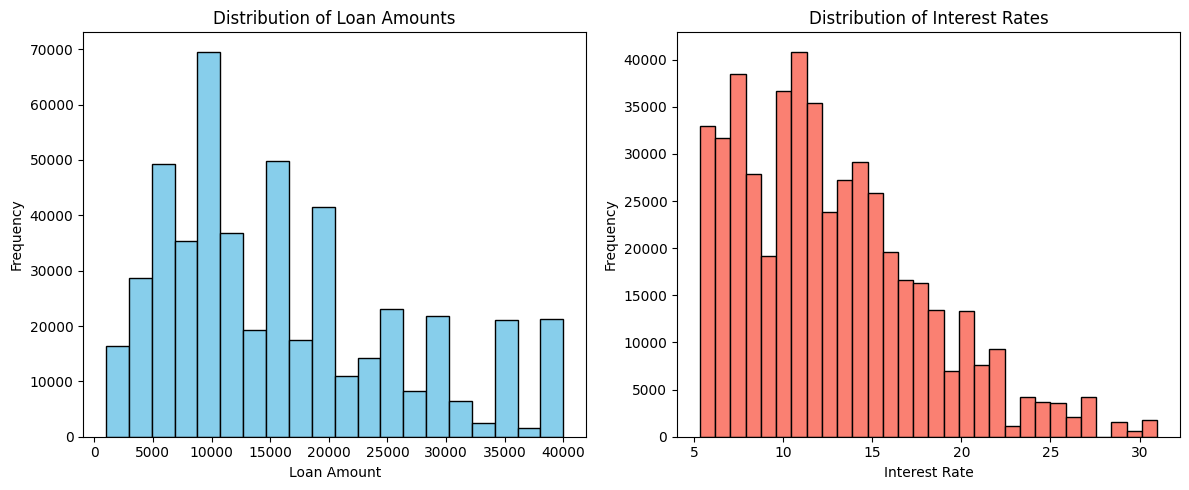

In [29]:
#Grpahing Loan Characteristics
# Assuming 'df' is your Spark DataFrame
# Convert Spark DataFrame to Pandas DataFrame for plotting
loan_amnt_pandas = df.select("loan_amnt").toPandas()
int_rate_pandas = df.select("int_rate").toPandas()


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(loan_amnt_pandas['loan_amnt'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Loan Amounts')


plt.subplot(1, 2, 2)
plt.hist(int_rate_pandas['int_rate'], bins=30, color='salmon', edgecolor='black')
plt.xlabel('Interest Rate')
plt.ylabel('Frequency')
plt.title('Distribution of Interest Rates')

plt.tight_layout()
plt.show()


Left-leaning data (right tail) - keep in mind for correlation estimates since this will impact those values.

In [30]:
# Calculate the average loan amount and interest rate by grade
avg_loan_int_rate = spark.sql("""
    SELECT
        grade,
        AVG(loan_amnt) AS avg_loan_amnt,
        ROUND(AVG(int_rate), 2) AS avg_int_rate  -- Change: Moved AS outside the ROUND function
    FROM df
    GROUP BY grade
    ORDER BY grade
""")
avg_loan_int_rate.show()

# Calculate the average difference in interest rates between consecutive grades
# and with respect to grade A
int_rate_spread = spark.sql("""
    WITH GradeAIntRate AS (  -- Subquery to get Grade A avg_int_rate
        SELECT avg_int_rate AS grade_a_int_rate
        FROM (
            SELECT grade, AVG(int_rate) AS avg_int_rate
            FROM df
            GROUP BY grade
        )
        WHERE grade = 'A'
    )
    SELECT
        grade,
        avg_int_rate,
        COALESCE(LAG(avg_int_rate, 1, avg_int_rate) OVER (ORDER BY grade), avg_int_rate) as prev_avg_int_rate,
        avg_int_rate - COALESCE(LAG(avg_int_rate, 1, avg_int_rate) OVER (ORDER BY grade), avg_int_rate) as int_rate_diff,
        avg_int_rate - grade_a_int_rate AS int_rate_diff_from_a  -- New column
    FROM (
        SELECT
            grade,
            AVG(int_rate) AS avg_int_rate
        FROM df
        GROUP BY grade
        ORDER BY grade
    )
    CROSS JOIN GradeAIntRate  -- Join to access Grade A avg_int_rate
""")
int_rate_spread.show()

+-----+------------------+------------+
|grade|     avg_loan_amnt|avg_int_rate|
+-----+------------------+------------+
|    A|15775.350651368206|        7.08|
|    B|16196.126339617304|       10.92|
|    C| 16177.99546708711|       14.71|
|    D| 15905.81713640182|       19.49|
|    E|15305.560976896297|       25.18|
|    F|19027.409448818897|       29.48|
|    G| 19741.50521609538|       30.82|
+-----+------------------+------------+

+-----+------------------+------------------+-----------------+--------------------+
|grade|      avg_int_rate| prev_avg_int_rate|    int_rate_diff|int_rate_diff_from_a|
+-----+------------------+------------------+-----------------+--------------------+
|    A| 7.081353114806082| 7.081353114806082|              0.0|                 0.0|
|    B| 10.91878513068961| 7.081353114806082|3.837432015883528|   3.837432015883528|
|    C|14.711079463935045| 10.91878513068961|3.792294333245435|   7.629726349128963|
|    D|19.489089737273535|14.711079463935045| 4.7

E, F , G loans have larger average loan sizes, which suggests loan_ammnt could be a strong predictor of grade. Inerest rates increase with grades, as expected.

+------------------+------+
|       loan_status| count|
+------------------+------+
|        Fully Paid| 40240|
|           Default|     9|
|   In Grace Period|  2901|
|       Charged Off|  6942|
|Late (31-120 days)|  6509|
|           Current|437318|
| Late (16-30 days)|  1323|
+------------------+------+



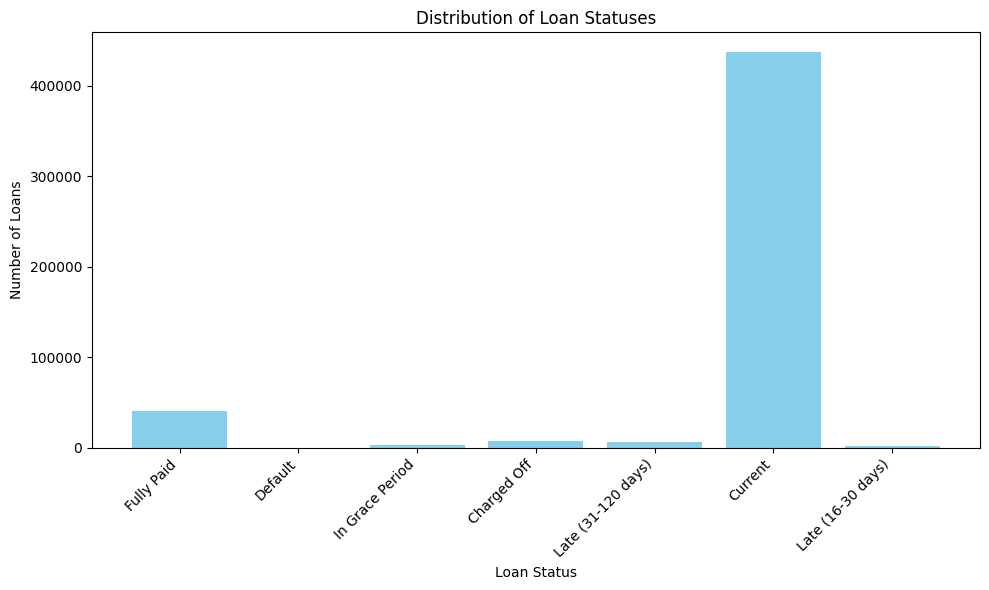

In [32]:
# Loan Status Distribution
loan_status_distribution = df.groupBy("loan_status").count()
loan_status_distribution.show()


import matplotlib.pyplot as plt

# Convert the Spark DataFrame to Pandas
loan_status_pandas = loan_status_distribution.toPandas()

# Create the bar chart
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(loan_status_pandas['loan_status'], loan_status_pandas['count'], color='skyblue')
plt.xlabel('Loan Status')
plt.ylabel('Number of Loans')
plt.title('Distribution of Loan Statuses')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


HEAVY class imbalance may pose challenges when analyzing this data.

In [35]:
spark.sql('SELECT verification_status from df').distinct().show()

# Replace "Source Verified" and "Verified" with "1" and "Not Verified" with "0"
# Update verification_status to 0 or 1
df = df.withColumn(
    "verification_status_binary",
    when(col("verification_status").isin(["Source Verified", "Verified"]), 1).otherwise(0)
)

# Display the modified DataFrame (optional)
df.select("verification_status_binary").distinct().show()

# Convert "term" to numeric by removing " months"
df = df.withColumn("term_numeric", regexp_replace(col("term"), " months", "").cast(IntegerType()))
df.select("term_numeric").distinct().show()

+-------------------+
|verification_status|
+-------------------+
|           Verified|
|    Source Verified|
|       Not Verified|
+-------------------+

+--------------------------+
|verification_status_binary|
+--------------------------+
|                         1|
|                         0|
+--------------------------+

+------------+
|term_numeric|
+------------+
|          60|
|          36|
+------------+



Bucket source verified with verified.

In [37]:
# Create a temporary column for the "trouble" indicator
df = df.withColumn(
    "trouble_indicator",
    when(
        ~col("loan_status").isin(["Fully Paid", "Current", "In Grace Period"]), 1
    ).otherwise(0),
)

# List of numeric features to check correlation
numeric_features = ["loan_amnt", "int_rate","installment", "term_numeric", "verification_status"]

# Get the schema to check column data types
schema = dict(df.dtypes)

# Calculate and print correlations only for valid numeric types
for feature in numeric_features:
    dtype = schema.get(feature)
    if dtype in ("double", "float", "int", "bigint"):
        correlation = df.stat.corr(feature, "trouble_indicator")
        print(f"Correlation between {feature} and trouble: {correlation}")
    else:
        print(f"Skipping {feature}: not a float or double (type = {dtype})")

# Drop the temporary column
df = df.drop("trouble_indicator")

Correlation between loan_amnt and trouble: 0.020256487477113085
Correlation between int_rate and trouble: 0.11715287542546356
Correlation between installment and trouble: 0.030615779172237043
Correlation between term_numeric and trouble: 0.02848919063799844
Skipping verification_status: not a float or double (type = string)


In [38]:
# Distribution of loan purposes - which purposes are more related to troubled loans?
spark.sql("""
SELECT purpose, COUNT(purpose)
FROM df
GROUP BY purpose
""").show()


+------------------+--------------+
|           purpose|count(purpose)|
+------------------+--------------+
|             other|         35018|
|    small_business|          4583|
|debt_consolidation|        259642|
|       credit_card|        127702|
|            moving|          3115|
|          vacation|          3501|
|  renewable_energy|           275|
|             house|          5430|
|               car|          4979|
|    major_purchase|         11622|
|           medical|          6622|
|  home_improvement|         32748|
|           wedding|             5|
+------------------+--------------+



These can be combined/bucketed based on similarity.

In [40]:
from pyspark.sql.functions import when, col, sum as _sum
# Create a temporary column for the "trouble" indicator
df = df.withColumn(
    "trouble_indicator",
    when(
        ~col("loan_status").isin(["Fully Paid", "Current", "In Grace Period"]), 1
    ).otherwise(0),
)

# Group by purpose and sum the trouble indicator
# Use _sum to avoid conflict with built-in sum
trouble_by_purpose = df.groupBy("purpose").agg(
    _sum("trouble_indicator").alias("trouble_count")
)

# Display the results
trouble_by_purpose.show()

# Drop the temporary column
df = df.drop("trouble_indicator")

+------------------+-------------+
|           purpose|trouble_count|
+------------------+-------------+
|             other|         1567|
|    small_business|          296|
|debt_consolidation|         7796|
|       credit_card|         2492|
|            moving|          164|
|          vacation|          131|
|  renewable_energy|           11|
|             house|          265|
|               car|          159|
|    major_purchase|          535|
|           medical|          326|
|  home_improvement|         1040|
|           wedding|            1|
+------------------+-------------+



Debt consolidation and credit card loans are riskier

In [47]:
from pyspark.ml.feature import Imputer

# Step 1: Create binary target
df = df.withColumn(
    "trouble_indicator",
    when(~col("loan_status").isin(["Fully Paid", "Current", "In Grace Period"]), 1).otherwise(0)
)

# Step 2: Cast features to DoubleType
numeric_features = ["loan_amnt", "int_rate", "installment", "term_numeric", "verification_status_binary"]  # Use the binary verification status
for feature in numeric_features:
    df = df.withColumn(feature, col(feature).cast(DoubleType()))

# Step 2.5: Impute missing values with the mean of the column
imputer = Imputer(
    inputCols=numeric_features,
    outputCols=numeric_features
).setStrategy("mean")  # You can change this to "median" or other strategies

# Step 3: Assemble features into a vector
assembler = VectorAssembler(
    inputCols=numeric_features,
    outputCol="features"
)

# Step 4: Define Logistic Regression model
lr = LogisticRegression(
    labelCol="trouble_indicator",
    featuresCol="features"
)

# Step 5: Create pipeline and fit
pipeline = Pipeline(stages=[imputer, assembler, lr])  # Add the imputer to the pipeline
model = pipeline.fit(df)

# Step 6: Show coefficients and intercept
lr_model = model.stages[-1]  # Extract the trained LogisticRegressionModel
print("Intercept:", lr_model.intercept)
print("Coefficients:")
for feature, coef in zip(numeric_features, lr_model.coefficients):
    print(f"  {feature}: {coef:.4f}")


Intercept: -5.109582137324404
Coefficients:
  loan_amnt: 0.0000
  int_rate: 0.1131
  installment: -0.0000
  term_numeric: -0.0094
  verification_status_binary: 0.3184


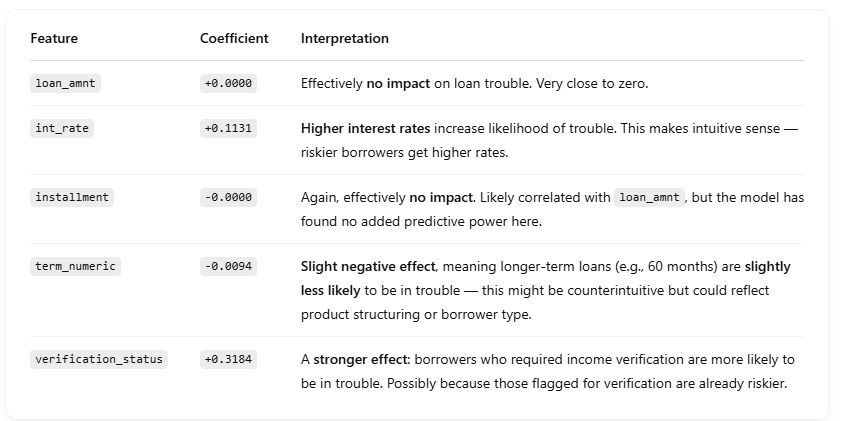

Results above are confusing and seem impacted by data imbalance. Now, interes rate is clearly an indicator of risk. Keep this in mind for leakage purposes / redundancy (grades --> int_rate --> risk --> grades). Verification status should also be studied.

+-------------------+------+-------+-------+--------------+--------------+-------------+-------------+------------+---------------+
|verification_status| count|avg_dti|std_dti|avg_annual_inc|std_annual_inc|avg_loan_amnt|std_loan_amnt|avg_int_rate|avg_installment|
+-------------------+------+-------+-------+--------------+--------------+-------------+-------------+------------+---------------+
|               NULL|495242|  19.67|  20.46|     80,093.99|     88,871.61|    16,025.02|    10,138.08|       12.73|         466.61|
+-------------------+------+-------+-------+--------------+--------------+-------------+-------------+------------+---------------+



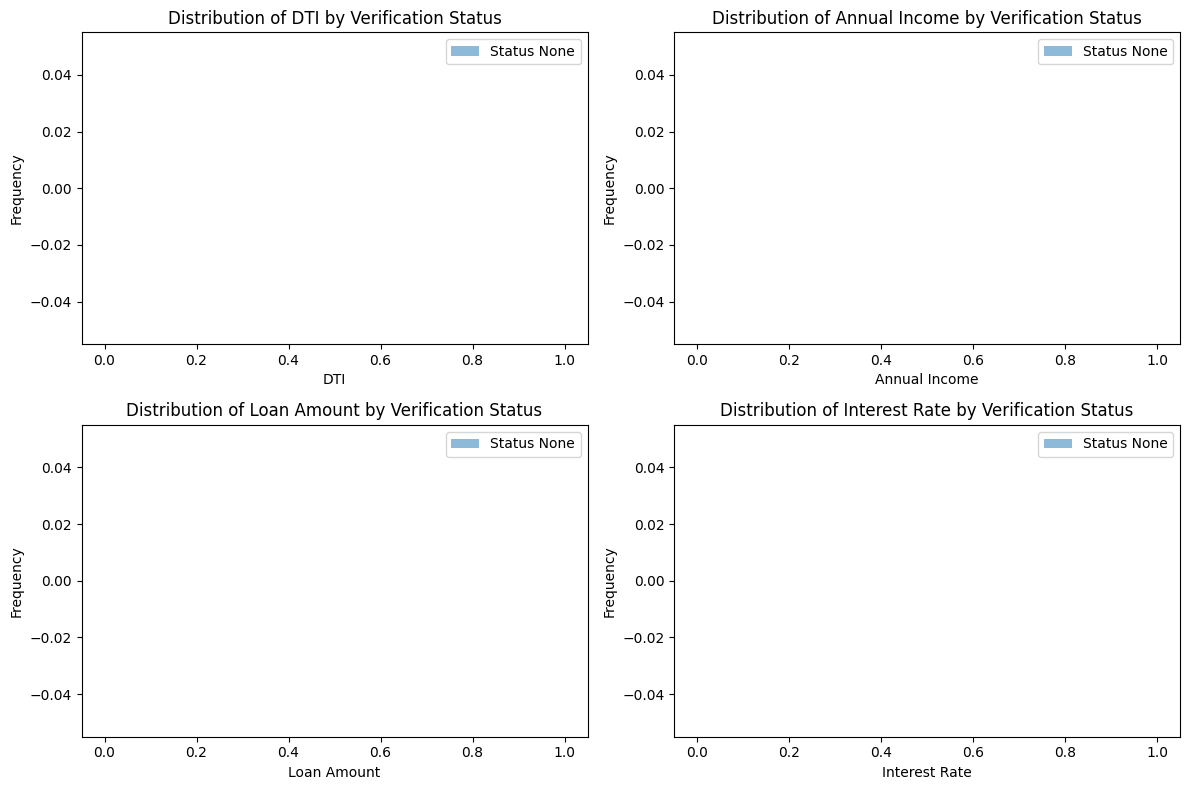

In [50]:
# Group by verification status and calculate summary statistics
verification_comparison = df.groupBy("verification_status").agg(
    count("*").alias("count"),
    mean("dti").alias("avg_dti"),
    stddev("dti").alias("std_dti"),
    mean("annual_inc").alias("avg_annual_inc"),
    stddev("annual_inc").alias("std_annual_inc"),
    mean("loan_amnt").alias("avg_loan_amnt"),
    stddev("loan_amnt").alias("std_loan_amnt"),
    mean("int_rate").alias("avg_int_rate"),
    mean("installment").alias("avg_installment"),
)

# Format numeric columns to 2 decimal places
verification_comparison = verification_comparison.select(
    "verification_status",
    "count",
    format_number("avg_dti", 2).alias("avg_dti"),
    format_number("std_dti", 2).alias("std_dti"),
    format_number("avg_annual_inc", 2).alias("avg_annual_inc"),
    format_number("std_annual_inc", 2).alias("std_annual_inc"),
    format_number("avg_loan_amnt", 2).alias("avg_loan_amnt"),
    format_number("std_loan_amnt", 2).alias("std_loan_amnt"),
    format_number("avg_int_rate", 2).alias("avg_int_rate"),
    format_number("avg_installment", 2).alias("avg_installment"),
)

# Display the comparison
verification_comparison.show()


# Plotting histograms
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Filter and plot histograms for each verification status
for status in df.select("verification_status").distinct().rdd.flatMap(lambda x: x).collect():
    subset = df.filter(col("verification_status") == status).toPandas()

    # Histogram 1: DTI
    axes[0, 0].hist(subset["dti"], bins=20, alpha=0.5, label=f"Status {status}")
    axes[0, 0].set_xlabel('DTI')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of DTI by Verification Status')
    axes[0, 0].legend()

    # Histogram 2: Annual Income
    axes[0, 1].hist(subset["annual_inc"], bins=20, alpha=0.5, label=f"Status {status}")
    axes[0, 1].set_xlabel('Annual Income')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution of Annual Income by Verification Status')
    axes[0, 1].legend()

    # Histogram 3: Loan Amount
    axes[1, 0].hist(subset["loan_amnt"], bins=20, alpha=0.5, label=f"Status {status}")
    axes[1, 0].set_xlabel('Loan Amount')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Loan Amount by Verification Status')
    axes[1, 0].legend()

    # Histogram 4: Interest Rate
    axes[1, 1].hist(subset["int_rate"], bins=20, alpha=0.5, label=f"Status {status}")
    axes[1, 1].set_xlabel('Interest Rate')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Distribution of Interest Rate by Verification Status')
    axes[1, 1].legend()

plt.tight_layout()
plt.show()

Loans that were verified have higher interest rates and loan amounts. Interestingly, also higher dti and annual income. This is likely why these where approved (given the higher loan amount borrowed on average).

In [52]:
# prompt: I need to see the number of loans grouped by verification status and grade
# Assuming 'df' is your Spark DataFrame
loan_counts_by_verification_grade = df.groupBy("verification_status", "grade").agg(count("*").alias("loan_count"))

# Calculate total loans for each verification status
total_loans_by_verification = loan_counts_by_verification_grade.groupBy("verification_status").agg(_sum("loan_count").alias("total_loans"))

# Join to get total loans for percentage calculation
loan_counts_with_percentage = loan_counts_by_verification_grade.join(total_loans_by_verification, on="verification_status")

# Calculate and add the percentage column
loan_counts_with_percentage = loan_counts_with_percentage.withColumn(
    "percentage", (col("loan_count") / col("total_loans")) * 100
)

loan_counts_with_percentage.orderBy("verification_status", "grade", ascending=True).show()


+-------------------+-----+----------+-----------+----------+
|verification_status|grade|loan_count|total_loans|percentage|
+-------------------+-----+----------+-----------+----------+
+-------------------+-----+----------+-----------+----------+



Verification loans A, B make up ~50% of loans. In verified, there is more loans with at the high-risk letters (presumably give the larger loan amounts associated with these loans).